In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
import sys

## Zadanie 1

In [3]:
grap = np.array([[0,2,4,1,2,0,0,0,0,0],#1
                [0,0,1,0,0,4,0,0,0,0],#2
                [0,0,0,0,2,3,0,0,0,0],#3
                [0,0,0,0,3,0,0,3,0,0],#4
                [0,0,0,0,0,2,1,4,0,0],#5
                [0,0,0,0,0,0,5,0,0,7],#6
                [0,0,0,0,0,0,0,0,3,6],#7
                [0,0,0,0,0,0,1,0,2,0],#8
                [0,0,0,0,0,0,0,0,0,5],#9
                [0,0,0,0,0,0,0,0,0,0]])#10

In [4]:
def graph_to_binary(g):
    a,b = g.shape
    mat_out = np.zeros((a,b))
    for i in range(a):
        for j in range(b):
            if g[i][j] != 0:
                mat_out[i][j] = 1
    return mat_out

In [5]:
## Funkcja do znajdowania zerowych kolumn
def find_col_zero(matrix):
    col_zero = []
    a,b = matrix.shape
    val_t2 = True
    for i in range(a):
        val_t2 = True
        ## Jeżeli wykryjemy niezerowy element to przechodzimy do nastepnej kolumny
        for j in range(b):
            if matrix[j][i] != 0:
                val_t2 = False
                break        
        if val_t2:
            col_zero.append(i)

    return col_zero

In [6]:
## Funkcja służąco do zmiany macierzy na której operujemy w celu odnalezienia obszarów
## Zwracamy macierz z usunieta kolumna i wierszem
def change_mat(mat_old, pos_cut):
    vert_good = []
    a,b = mat_old.shape
    vert = np.array([i for i in range(a)])

    for i in vert:
        if i not in pos_cut:
            vert_good.append(i)
    mat_old =  mat_old[vert_good,:]
    return mat_old[:,vert_good]


In [7]:
## Funkcja zwraca kolejność etapów wykonywania zadania, zwracana jest lista kolumn
## które stanowią jednen obszar
def renumbered_vert(graph):
    vert_list = [i for i in range(graph.shape[0])]
    area = []
    to_cut_graph = graph_to_binary(graph)
    i = 0
    ## Dopóki nie wykorzystamy każdego wierzchołka,
    ## znajdujemy kolumny zerowe -> dodajemy usunięte wierzchołki do listy w celu zapamietaniu ich
    ## następnie usuwamy ją z listy możliwych wyborów pamietajac o zmianie pozycji usunięcia
    ## Zwracamy area
    while len(vert_list) != 0:
        col_to_cut = find_col_zero(to_cut_graph)

        arr_help = []
        for j in col_to_cut:
            arr_help.append(vert_list[j] + 1)
            # new_vert.append(vert_list[j])

        p = 0
        for i in range(len(col_to_cut)):
            vert_list.pop(col_to_cut[i] - p)
            p += 1

        area.append(arr_help)
        to_cut_graph = change_mat(to_cut_graph, col_to_cut)
    return area
    # print(area)

In [8]:
## Podział w kolejności na obszary wykonywania
a = renumbered_vert(grap)
print(a)

[[1], [2, 4], [3], [5], [6, 8], [7], [9], [10]]


In [9]:
## Funkcja celem której będzie zmiania wartości 0 w macierzy na np.Inf
## Ma to na celu łatwiejsze przetworzenie jej aby uzyskać najdłuższą trasę
def zero_to_inf(mat):
    mat = mat.astype('float32')
    x,y = mat.shape
    for i in range(x):
        for j in range(y):
            if mat[i,j] == 0:
                mat[i,j] = np.inf
    return mat

In [10]:
## Zmiana grafu na graf z np.inf
graph = zero_to_inf(grap)

In [11]:
## Funkcja połączona działaniem z longestPath
## Ma na celu zaktualizowanie tablicy Stack w taki sposób
## abyśmy mogli przejść po wierzchołkach tak aby odnaleźć najdłuższe trasy
def top_sort(g_top, v):
    global visited, Stack   
    visited[v] = True
    ## Bedziemy odwiedzali wierzchołki dla kolejnych połączeń rekurencyjnie,
    ## dochodzą do każdego wierzchołka na każdem możliwy do osiągniecia sposób
    for i in range(len(g_top[v])):
        if (not visited[i]):
            top_sort(g_top, i)
    Stack.append(v)
    

In [12]:
## Funkcja ma na celu znalezienie najdłuższej drogi do każdego wierzchołka
## zaczynając od zadanego
## paramter domyślny direction służy tylko do obliczania najdłuższych dróg 
## w macierzy po odwróceniu
## Zwracamy wartosci drogi do wierzchołkow oraz trase
def longestPath(graph, start, direction = 1):
    global visited, Stack
    Stack = []
    V = graph.shape[0]
    V_len = V
    dist = [-np.inf for i in range(V_len)]
    trace = []
    ## Aktualizacja kolejności w jakiej będziemy odwiedzać wierzchołki
    visited = [False for i in range(V)]
    for i in range(V_len):
        if (visited[i] == False):
            top_sort(graph, i)

    
    ## Aktualizujemy wartości tablicy dystansów w tym celu wykorzystujemy Stack
    ## Dopóki nie odwiedzimy wszystkich możliwych ścieżek, rozpatrujemy kolejne wierzhołki
    ## i usuwamy je z listy, rozpatrujemy możliwy brak połączenia,a natępnie
    ## aktualizujemy drogi, jeżeli znajdziemy dłuższa to ją wybieramy, wyznaczamy
    ## również trasy po jakich się poruszamy
    dist[start] = 0
    if not direction:
        Stack = Stack[::-1]
    while (len(Stack) > 0):
        u = Stack[-1]
        del Stack[-1]
        # print(u)
        arr_help = []
        for i in range(V):
            if graph[u][i] != np.inf:
                arr_help.append(i)
                
        if (dist[u] != np.inf):
            for i in arr_help:
                if (dist[i] < dist[u] + graph[u][i]) and ((dist[u] + graph[u][i]) != np.inf):
                    dist[i] = dist[u] + graph[u][i]
                    trace.append((u+1,i+1))

    return dist,trace

In [13]:
## Wyznaczenie drog i wartosci dla poczatku zadania do konca
## Najwcześniejsza i najpóźniejsza realizacja
a,trace = longestPath(graph, 0)
b,trace1 = longestPath(graph.T, 9, 0)
b = a[-1] - np.array(b)

In [14]:
## Funckja służaca do utworzenia tablicy połączeń w grafie 
## zapisanym jako macierz połączen z wagami
def find_connections(mat):
    arr = []
    x,y = mat.shape
    for i in range(x):
        for j in range(y):
            if mat[i,j] != np.inf:
                arr.append((i + 1,j + 1))
    return arr

In [15]:
## Funkcja służąca do znajdowania najdłuższej możliwej trasy w grafie
## na podstawie grafu połączeń oraz wartości najdłuższej trasy
## zwraca ścieżke krytyczna
def find_longest_path(graph, trace_graph, max_dist):
    arr = []
    arr_work = []
    trace = list(reversed(trace_graph))
    ##Przygotowanie danych 
    for i in trace:
        arr_work.append((i[1], i[0]))
    

    ## Ustawiamy jako wierzchołek końcowy 10,
    ## bierzymy dystans jako kryterium poszukiwan
    ## acc służy do przechodzenia do nastepnych par połączeń
    a = 10
    dist = 0
    acc = 0
    ## Dopóki nie dojdziemy do wierzchołka poczatkowego po zadanej wartosci trasy
    ## Wybieramy kolejne połączenia i patrzymy ich powiązanie, aktualizujac ciagle acc
    while a != 1 and dist != max_dist:
        first,second = arr_work[acc]
        if first == a:
            dist += graph[second - 1][first - 1]
            arr.append((second,first))
            a = second
        ## Gdybyśmy doszli do wierzchołka 1 ale po innej trasie to usuwamy ostanie połącznie
        ## acc -= 5 służy tylko do powrotu wcześniej do tablicy w celu poszukiwań innych tras
        ## Część tą można by było bardziej zoptymalizować i uodpornić na błędy, tworzac
        ## np ostatni indeks odwiedzony i przenieść koło niego
        if a == 1:
            acc -= 5
            arr.pop(-1)
            arr_work.pop(acc)
        acc += 1
    arr.append((1,arr[-1][0]))
    return arr



In [16]:
## Ścieżka krytyczna
arr = find_longest_path(graph, trace, a[-1])

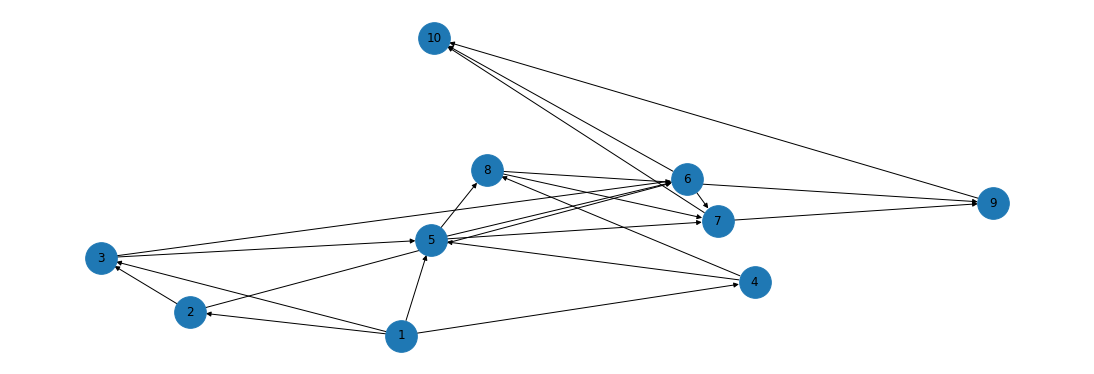

In [17]:
## Wyświetlenie grafu
con = find_connections(graph)
Graph = nx.DiGraph()
plt.figure(figsize=(15,5))

color_map = []
for i in con:
    Graph.add_edge(i[0], i[1])
nx.draw(Graph, with_labels = True,node_size=1e3)
plt.show()


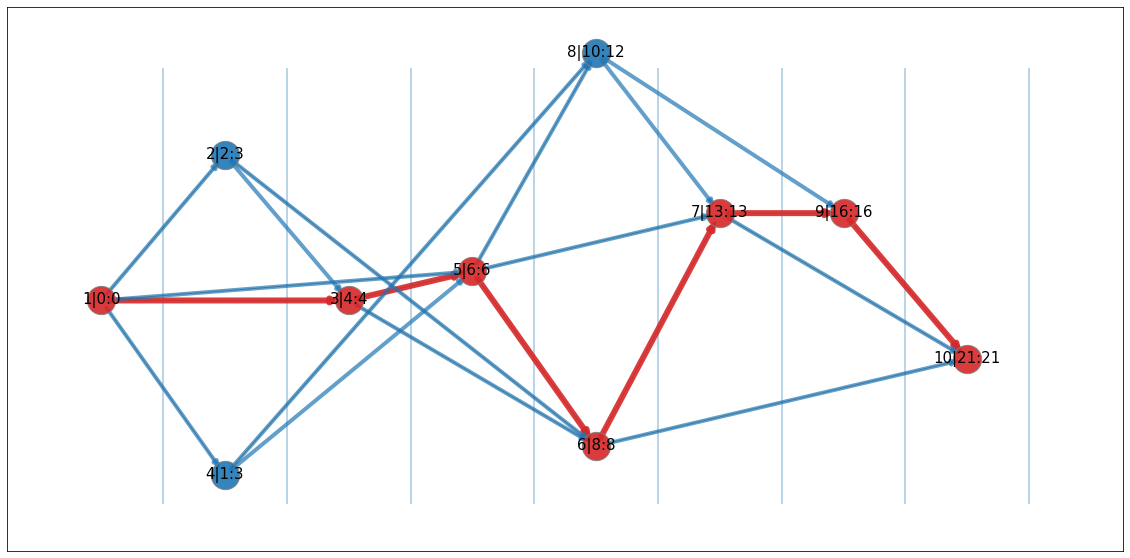

In [18]:
## Narysowanie grafu wraz z podziałem na obszary oraz z ścieżką krytyczną

Graph = nx.DiGraph()

node_red = []
node_blue = []
plt.figure(figsize=(20,10))
for i in trace:
    if i in arr:
        Graph.add_edge(i[0], i[1])
        if i[0] not in node_red:
            node_red.append(i[0])
        if i[1] not in node_red:
            node_red.append(i[1])
    else:
        Graph.add_edge(i[0], i[1])

for i in range(1,11):
    if i not in node_red:
        node_blue.append(i)

connection = []
for i in con:
    if i not in arr:
        connection.append(i)

# [[1], [2, 4], [3], [5], [6, 8], [7], [9], [10]]
            
pos = {1:(100,70), 2:(200,120), 3:(300,70),4:(200,10),5:(400,80),6:(500,20),7:(600,100),8:(500,155),9:(700,100),10:(800,50)}         
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(Graph, pos, nodelist=node_red, node_color="tab:red", **options)
nx.draw_networkx_nodes(Graph, pos, nodelist=node_blue, node_color="tab:blue", **options)
nx.draw_networkx_edges(Graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    Graph,
    pos,
    edgelist=arr,
    width=6,
    alpha=0.9,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    Graph,
    pos,
    edgelist=connection,
    width=4,
    alpha=0.7,
    edge_color="tab:blue",
)

labels = {}
for i in range(1,11):
    val1 = str(i)
    val2 = str(int(a[i - 1]))
    val3 = str(int(b[i - 1]))
    labels[i] = val1 + "|" + val2 + ":" + val3
nx.draw_networkx_labels(Graph, pos, labels, font_size=15, font_color="black")


screnn_con = [(1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16)]
pos_screen = {}
x_pos_screen = 150
for i in range(1,17):
    if i%2 == 0:
        pos_screen[i] = (x_pos_screen,150)
        x_pos_screen += 100
    else:
        pos_screen[i] = (x_pos_screen,0)


nodelist_screen = np.array([i for i in range(1,17)])
G = nx.Graph()
options2 = {"edgecolors": "tab:gray", "node_size": 0, "alpha": 0.4}
nx.draw_networkx_nodes(G, pos_screen, nodelist=nodelist_screen, node_color="tab:gray", **options2)
nx.draw_networkx_edges(
    G,
    pos_screen,
    edgelist=screnn_con,
    width=2,
    alpha=0.3,
    edge_color="tab:blue",
)
plt.show()

## Zadanie 2


In [19]:
## Znajdowanie parametrów P(w) oraz P(j)
def find_val_p(graph, connection, Ti, Tj):
    Pw = []
    Pp = []
    for i in range(len(connection)):
        val1, val2 = connection[i]
        Pw.append(Ti[val1 - 1])
        Pp.append(Tj[val2 - 1] - graph[val1 - 1,val2 - 1])
    return Pw, Pp

In [20]:
## Znajdowanie parametrów K(w) oraz K(j)
def find_val_k(graph, connection, Ti, Tj):
    Kw = []
    Kp = []
    for i in range(len(connection)):
        val1, val2 = connection[i]
        Kw.append(Ti[val1 - 1] + graph[val1 - 1,val2 - 1])
        Kp.append(Tj[val2 - 1])
    return Kw, Kp

In [21]:
Pw, Pp = find_val_p(grap,con,a,b)
Kw, Kp = find_val_k(grap,con,a,b)

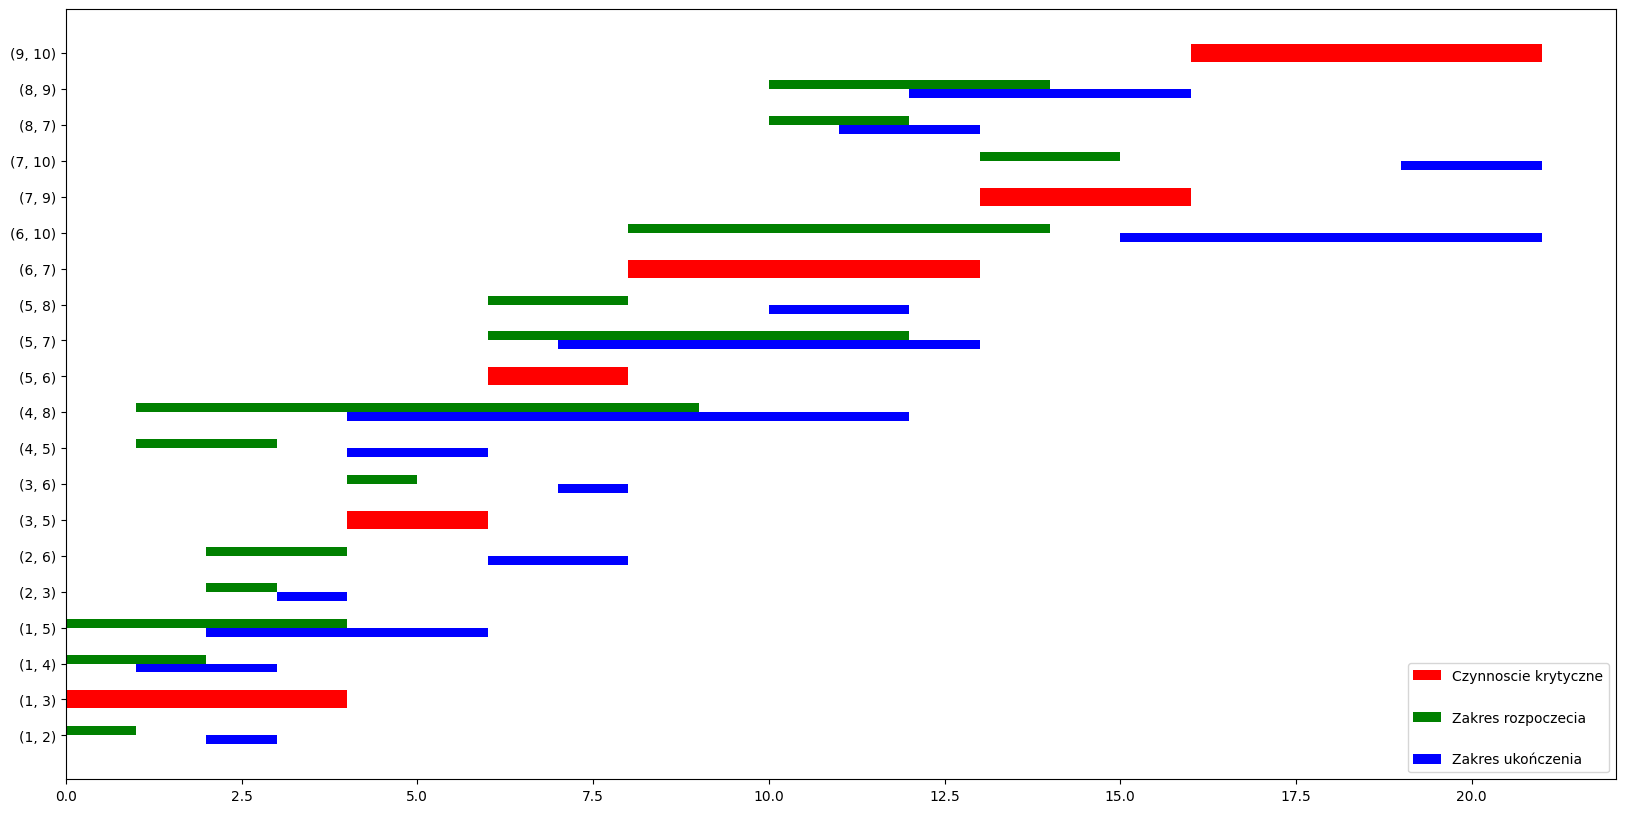

In [23]:
## Ma na celu utworzenie wykresów Gantt'a
fig, ax = plt.subplots(figsize=(20,10))
y_axis = []
for i in con:
    y_axis.append(str(i))


## Znajdowanie czynności krytycznych
x_bar_critical1 = []
x_bar_critical2 = []
for i in range(len(Pw)):
    if Pw[i] == Pp[i]:
        x_bar_critical1.append(Pw[i])
        x_bar_critical2.append(Kp[i])
    else:
        x_bar_critical1.append(0)
        x_bar_critical2.append(0)


x_bar_start1 = []
x_bar_start2 = []
for i in range(len(Pw)):
    if not (Pw[i] == Pp[i]):
        x_bar_start1.append(Pw[i])
        x_bar_start2.append(Pp[i])
    else:
        x_bar_start1.append(0)
        x_bar_start2.append(0)


x_bar_finish1 = []
x_bar_finish2 = []
for i in range(len(Pw)):
    if not (Kw[i] == Kp[i]):
        x_bar_finish1.append(Kw[i])
        x_bar_finish2.append(Kp[i])
    else:
        x_bar_finish1.append(0)
        x_bar_finish2.append(0)



##Kryczytny 
ax.barh(y_axis, x_bar_critical2, 0.5, color='red')
ax.barh(y_axis, x_bar_critical1, 0.5, color='white')

## Rozpoczenie
ax.barh(y_axis, x_bar_start2, 0.25,color='green', align='edge')
ax.barh(y_axis, x_bar_start1, 0.25,color='white', align='edge')

# Zakończenie
ax.barh(y_axis, x_bar_finish2, -0.25,color='blue', align='edge')
ax.barh(y_axis, x_bar_finish1, -0.25,color='white', align='edge')


ax.legend(['Czynnoscie krytyczne', '','Zakres rozpoczecia','','Zakres ukończenia'], loc='lower right')
plt.show()


## Zadanie 3